<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="float:right; max-width: 250px; display: inline"  alt="Wikistat"/></a>

</center>

# [Scénarios d'Exploration Statistique](https://github.com/wikistat/Exploration)

# Analyse de signaux  issus d'un *smartphone* en <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="Python"/></a> avec <a href="http://scikit-learn.org/stable/#"><img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png" style="max-width: 100px; display: inline" alt="Scikit-Learn"/></a>
##  Signaux bruts: visualisation des données et [ACP ](http://wikistat.fr/pdf/st-m-explo-acp.pdf)

### Résumé
Ce cas d'usage de [reconnaissance d'activités humaines](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) à partir des enregistrements d'un smartphone (gyroscope, accéléromètre) est traité pour illustrer les principales étapes d'exploration  communes en *science des données* et appliquables à des signaux échantillonnés. Ce calepin propose de visualiser ces signaux puis de réaliser des ACP afin d'identifier les problèmes spécifiques soulevés par ce type de données.

##  1 Introduction
### 1.1  Contexte
Les données sont issues de la communauté qui vise la reconnaissance d'activités humaines (*Human activity recognition, HAR*) à partir d’enregistrements, par exemple du gyroscope et de l'accéléromètre d'un smartphone alors que le porteur produit une activité déterminée a priori pendnat un laps de temps défini.

Voir à ce propos l'[article](https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2013-11.pdf) relatant un colloque de 2013.  

Les données publiques disponibles et largement étudiées ont été acquises, décrites et analysées par [Anguita et al. (2013)](). Elles sont accessibles sur le [dépôt](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) de l'University California Irvine (UCI) consacré à l'apprentissage machine ainsi que sur le site *Kaggle*.

L'archive contient les données brutes: accélérations échantillonnnées à 64 htz pendant 2s. Les accélérations en x, y, et z, chacune de 128 colonnes, celles en y soustrayant la gravité naturelle ainsi que les accélérations angulaires (gyroscope) en x, y, et z soit en tout 9 fichiers.

Ce sont ces données brutes qui sont analysées tandis qu'un [autre calepin]() étudie des transformations expertes ou métier de celles-ci sous la forme de nouvelles variables ou *features*. 

### 1.2 Objectifs
L'[analyse des nouvelles variables]() issues de transformations des signaux (entropie, variance, corrélations, Fourier...) conduit à d'excellents résultats au moment de la reconnaisance de l'activité. Néanmoins, il est nécessaire de  s'intéresser directement aux données brutes avec pour objectif d'économiser les calculs lourds et énergivores pour un système embarqué ou porté par un individu. Un [autre calepin] aborde cette question: obtenir la même qualité de reconnaissance que sur les variables transformées mais par un réseau de neurones (*deep learning*) qui, une fois implémenté, sera de faible consommation comme peuvent l'être les circuits de reconnaissance des visages sur un appareil photo.

Comme pour les données métier, l'étude commence par une exploration: visualisation des données, réduction de dimension par ACP.

### 1.3 Librairies
Importation des principales librairies.

In [1]:
import pandas as pd
import numpy as np
import copy
import random
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.decomposition as sdec 

## 2 Prise en charge des données
### 2.1 Source

Les données sont celles originales du dépôt de l'[UCI](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Elle doivent être préalablement téléchargées en cliquant [ici](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip).

Elles contiennent deux jeux de dimensions différentes, chacun partagé en apprentissage et test. L'échantillon test n'est utilisé que pour dans les calepins d'apprentisage. 

1. Multidimensionel: un individus est constitué de 9 Séries Temporelles de *dimensions* $(N, 128, 9)$
2. Unidimensionnel: Les 9 Séries Temporelles sont concaténées pour constituer un vecteur de 128*9 = 1152 variables de *dimensions* $(N, 1152)*

*N.B.* La structure des données est nettement plus complexe que celles couramment étudiées dans ce dépôt. Le code a été structuré en une séquence de fonctions afin d'en faciliter la compréhension. L'outil "calepin" atteint ici des limites pour la réalisation de codes complexes.

### 2.2 Structurer les données
Définir le chemin d'accès aux données puis les fonctions utiles.

In [2]:
# Attention à la définition du chemin ci-dessous:
DATADIR_UCI = '/home-local/pbesse/Documents/2-Data_files/HAR/UCI HAR Dataset'
# Liste des fichiers afin d'automatiser la lecture.
SIGNALS = [ "body_acc_x", "body_acc_y", "body_acc_z", "body_gyro_x", "body_gyro_y", "body_gyro_z", "total_acc_x", "total_acc_y", "total_acc_z"]

# Fonctions permettant de lire la séquence des fichiers avant de restructurer les données 
# dans le fortmat recherché.
def my_read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

def load_signal(data_dir, subset, signal):
    filename = data_dir+'/'+subset+'/Inertial Signals/'+signal+'_'+subset+'.txt'
    x = my_read_csv(filename).as_matrix()
    return x 

def load_signals(data_dir, subset, flatten = False):
    signals_data = []
    for signal in SIGNALS:
        signals_data.append(load_signal(data_dir, subset, signal)) 
    if flatten :
        X = np.hstack(signals_data)
    else:
        X = np.transpose(signals_data, (1, 2, 0))    
    return X 

def load_y(data_dir, subset, dummies = False):
    filename = data_dir+'/'+subset+'/y_'+subset+'.txt'
    y = my_read_csv(filename)[0]
    if dummies:
        Y = pd.get_dummies(y).as_matrix()
    else:
        Y = y.as_matrix()
    return Y 

Lecture des données

In [3]:
#Multidimensional Data
X_train, X_test = load_signals(DATADIR_UCI, 'train'), load_signals(DATADIR_UCI, 'test')
# Flattened Data
X_train_flatten, X_test_flatten = load_signals(DATADIR_UCI, 'train', flatten=True), load_signals(DATADIR_UCI, 'test', flatten=True)

# Label Y
Y_train_label, Y_test_label = load_y(DATADIR_UCI, 'train', dummies = False), load_y(DATADIR_UCI, 'test', dummies = False)
#Dummies Y (For Keras)
Y_train_dummies, Y_test_dummies = load_y(DATADIR_UCI, 'train', dummies = True), load_y(DATADIR_UCI, 'test', dummies = True)

N_train = X_train.shape[0]
N_test = X_test.shape[0]

/home-local/pbesse/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
/home-local/pbesse/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home-local/pbesse/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Vérification des dimensions afin de s'assurer de la bonne lecture des fichiers.

In [4]:
print("Dimension")
print("Données Multidimensionelles, : " + str(X_train.shape))
print("Données Unimensionelles, : " + str(X_train_flatten.shape))
print("Vecteur réponse (scikit-learn) : " + str(Y_train_label.shape))
print("Matrice réponse(Keras) : " + str(Y_train_dummies.shape))

Dimension
Données Multidimensionelles, : (7352, 128, 9)
Données Unimensionelles, : (7352, 1152)
Vecteur réponse (scikit-learn) : (7352,)
Matrice réponse(Keras) : (7352, 6)


## 3 Visualisations
Certre phase est essentielle à la bonne compréhension des données, de leur structure et don cdes problèmes qui vont être soulevés par la suite. La visualisation est très élémentaire d'un point de vue méthodologique mais nécessite des compétences avancées dans 
### 3.1 Fonctions utiles

In [5]:
# Liste des couleurs
CMAP = plt.get_cmap("Accent")
# Liste des types de signaux
SIGNALS = ["body_acc x", "body_acc y", "body_acc z", 
                "body_gyro x", "body_gyro y", "body_gyro z", 
               "total_acc x", "total_acc y", "total_acc z"] 
# Dictionnaire en clair des activités expérimentées (contexte supervisé)
ACTIVITY_DIC = {1 : "WALKING",
2 : "WALKING UPSTAIRS",
3 : "WALKING DOWNSTAIRS",
4 : "SITTING",
5 : "STANDING",
6 : "LAYING"}

# Fonction pour le tracé d'un signal
def plot_one_axe(X, fig, ax, sample_to_plot, cmap):
    for act,Xgb in X.groupby("Activity"):
        Xgb_first_values = Xgb.values[:sample_to_plot,:-1]
        x = Xgb_first_values[0]
        ax.plot(x, linewidth=1, color=cmap(act-1), label = label_dic[act])
        for x in Xgb_first_values[1:]:
            ax.plot(x, linewidth=1, color=cmap(act-1))

            
def plot_one_axe_shuffle(X, fig, ax, sample_to_plot, cmap):
    plot_data = []
    for act,Xgb in X.groupby("Activity"):
        Xgb_first_values = Xgb.values[:sample_to_plot,:-1]
        x = Xgb_first_values[0]
        ax.plot(x, linewidth=1, color=cmap(act-1), label = label_dic[act])
        for x in Xgb_first_values[1:]:
            plot_data.append([x,cmap(act-1)])
    random.shuffle(plot_data)
    for x,color in plot_data:
        ax.plot(x, linewidth=1, color=color)

### 3.2 Tracés de tous les signaux
Tous le signaux sont tracés par type en superposant les activités.

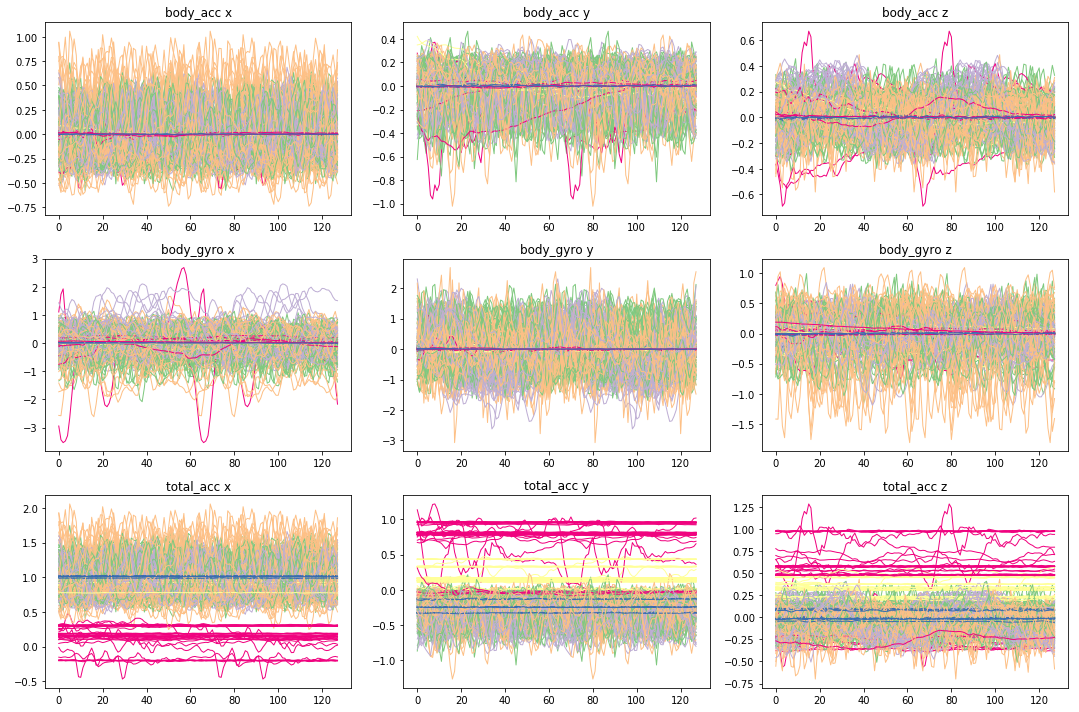

In [6]:
sample_to_plot = 50
index_per_act = [list(zip(np.repeat(act, sample_to_plot), np.where(Y_train_label==act)[0][:sample_to_plot])) for act in range(1,7)]
index_to_plot = list(itertools.chain.from_iterable(index_per_act))
random.shuffle(index_to_plot)

fig = plt.figure(figsize=(15,10))
for isignal in range(9):
    ax = fig.add_subplot(3,3,isignal+1)
    for act , i in index_to_plot:
        ax.plot(range(128), X_train[i,:,isignal],color=CMAP(act-1), linewidth=1)
        ax.set_title(SIGNALS[isignal])
plt.tight_layout()

**Q** Apprécier la difficulté à distinguer les activités.

### 3.3 Par signal 
Un seul signal acélération en x est tracé en distinguant les activités.

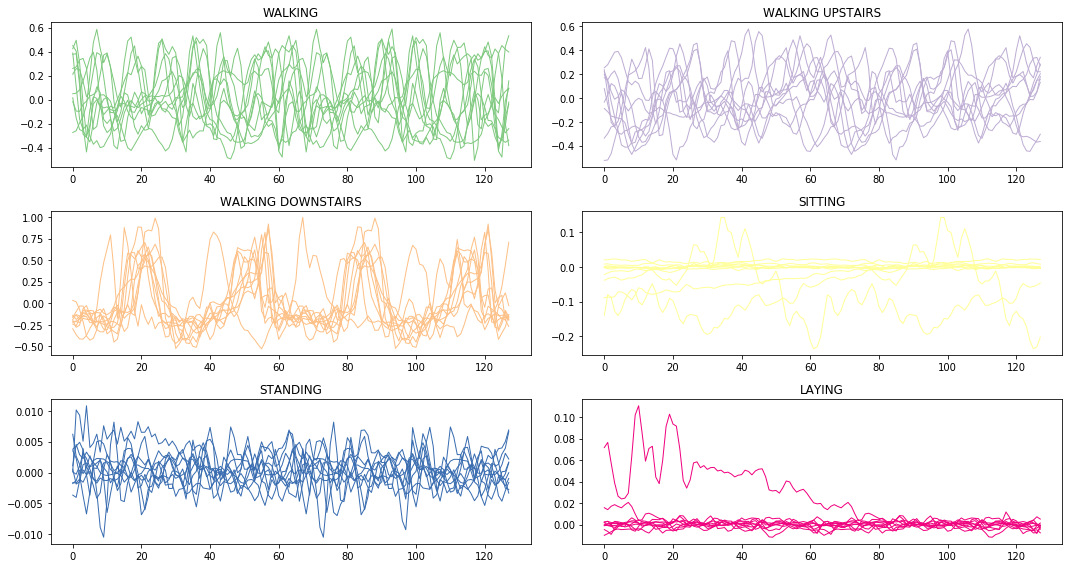

In [7]:
sample_to_plot = 10
isignal = 1
index_per_act_dict = dict([(act, np.where(Y_train_label==act)[0][:sample_to_plot]) for act in range(1,7)])


fig = plt.figure(figsize=(15,8), num=SIGNALS[isignal])
for act , index in index_per_act_dict.items():
    ax = fig.add_subplot(3,2,act)
    for x in X_train[index]:
        ax.plot(range(128), x[:,0],color=CMAP(act-1), linewidth=1)
    ax.set_title(ACTIVITY_DIC[act])
plt.tight_layout()

**Q** Quelles est l'activité qui semble se distinguer facilement des autres? 

**Q** Observer l'un des signaux, par exemple `Walking upstairs`. Qu'est ce qui fait que, pour ces signaux ou courbes, une métrique euclidienne classique ($L_2$) est inopérante? 

**Q** Corrélativement pourquoi est-il intéressant de décomposer un signal dans le domaine des fréquences?

## 4 [Analyse en composantes principales](http://wikistat.fr/pdf/st-m-explo-acp.pdf)
Les ACP ne sont pas réduites car cette transformation n'a finalement pas d'effet sensible sur la discrimination des classes.

Fonction graphique pour la représentation d'un plan factoriel

In [8]:
def plot_pca(X_R, ytrain, fig, ax, nbc, nbc2, label_dic=ACTIVITY_DIC, cmaps = plt.get_cmap("Accent")
):
    for i in range(6):
        xs = X_R[ytrain==i+1,nbc-1]
        ys = X_R[ytrain==i+1, nbc2-1]
        label = label_dic[i+1]
        color = cmaps(i)
        ax.scatter(xs, ys, color=color, alpha=.8, s=10, label=label)
        ax.set_xlabel("PC%d : %.2f %%" %(nbc,pca.explained_variance_ratio_[nbc-1]*100), fontsize=15)
        ax.set_ylabel("PC%d : %.2f %%" %(nbc2,pca.explained_variance_ratio_[nbc2-1]*100), fontsize=15)

### 4.1 Sur un Signal
Calcul de l'ACP sur un seul signal: accélération angulaire (gyroscope) en y. Il suffit de changer la valeur ci-dessous de `isignal` pour en étudier d'autres.

In [9]:
pca = sdec.PCA()
# CHoix du signal
isignal = 4
signal = SIGNALS[isignal]
print("ACP Sur signal : " +signal)
X_r = pca.fit_transform(X_train[:,:,isignal])

ACP Sur signal : body_gyro y


Représentation des parts de variances.

Text(0.5, 0.98, 'Résultat ACP sur Signal : body_gyro y')

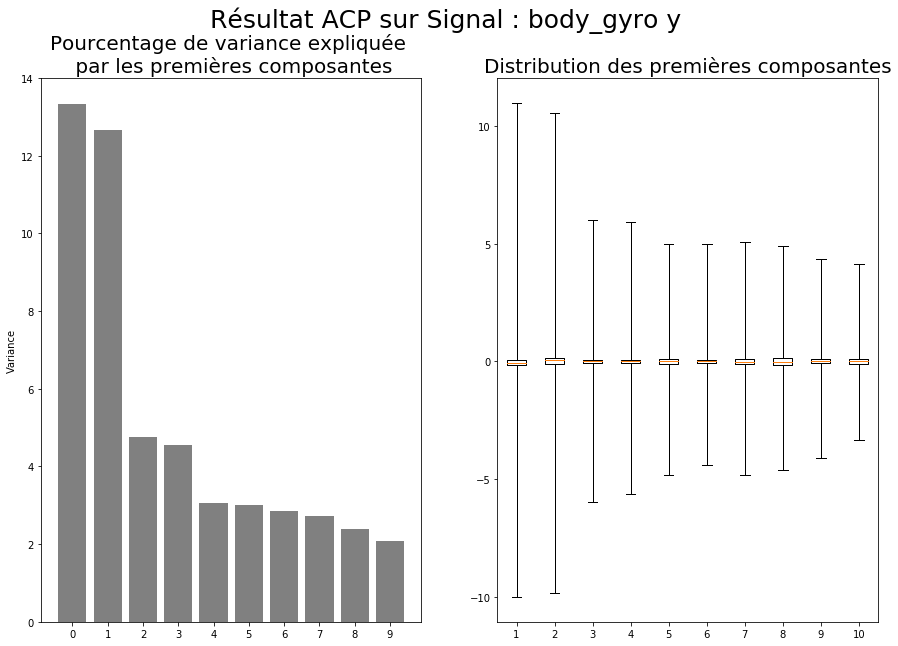

In [10]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), pca.explained_variance_ratio_[:10]*100, align='center',
        color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("", fontsize=35)
ax.set_title(u"Pourcentage de variance expliquée \n par les premières composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_r[:,0:10],whis=100)
ax.set_title(u"Distribution des premières composantes", fontsize=20)

fig.suptitle(u"Résultat ACP sur Signal : " + signal, fontsize=25)


**Attention**: les diagrammes boîtes sont très perturbés pas les distributions des composantes avec une très forte concentration autour de 0 et énormément de valeurs atypiques. D'où l'utilisation du paramètre `whis=100` pour rallonger les moustaches.

**Q** Que osnt les graphes ci-dessus. Quelles interprétations ou absence d'interprétation en tirer?

Représentation du premier plan factoriel;

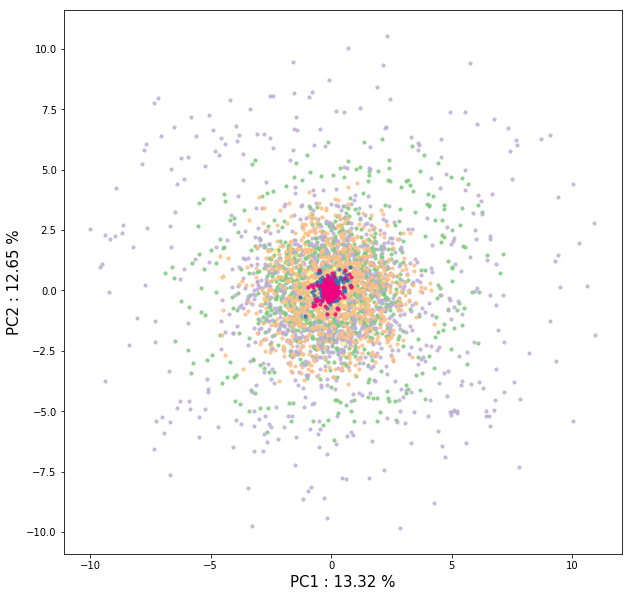

In [11]:
fig = plt.figure(figsize=(10,10), )
ax = fig.add_subplot(1,1,1)
plot_pca(X_r, Y_train_label,fig ,ax ,1 ,2)

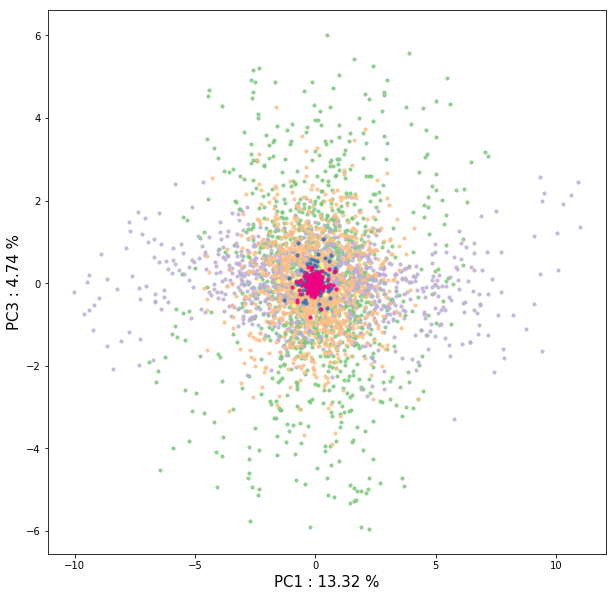

In [12]:
fig = plt.figure(figsize=(10,10), )
ax = fig.add_subplot(1,1,1)
plot_pca(X_r, Y_train_label,fig ,ax ,1 ,3)

Faire varier `isignal` pour comparer.

**Q** la discrimination des classes semble-elle facile à partir des signaux bruts?

### 4.2 Sur tous les signaux
Tous les signaux sont concaténés à plat en un seul signal.

In [13]:
pca = sdec.PCA()
print("ACP Sur tous les signaux")
X_r = pca.fit_transform(X_train_flatten)

ACP Sur tous les signaux


Text(0.5, 0.98, 'Résultat ACP')

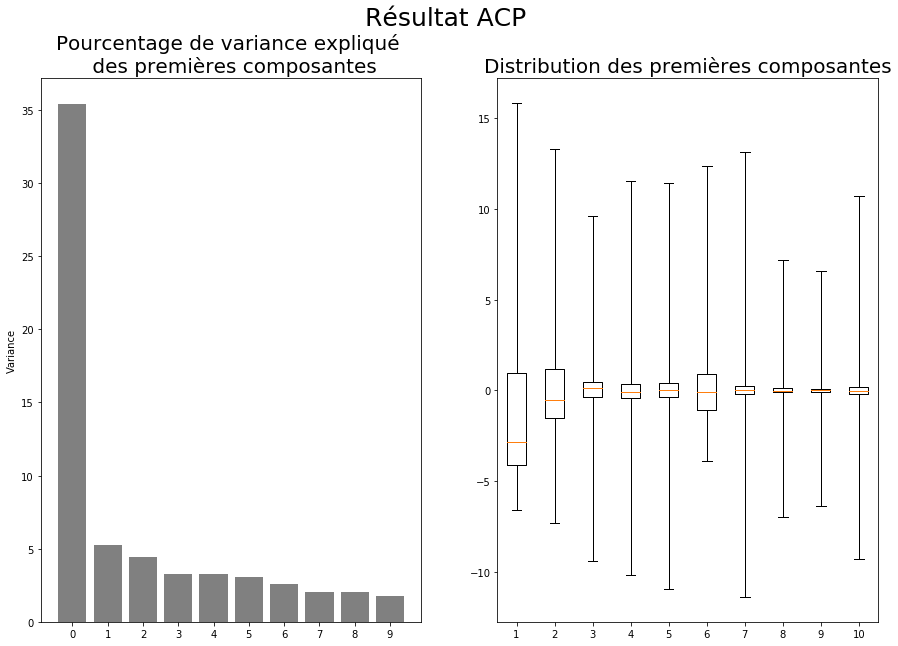

In [14]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), pca.explained_variance_ratio_[:10]*100, align='center',
        color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("", fontsize=35)
ax.set_title(u"Pourcentage de variance expliqué \n des premières composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_r[:,0:10],whis=100)
ax.set_title(u"Distribution des premières composantes", fontsize=20)

fig.suptitle(u"Résultat ACP", fontsize=25)

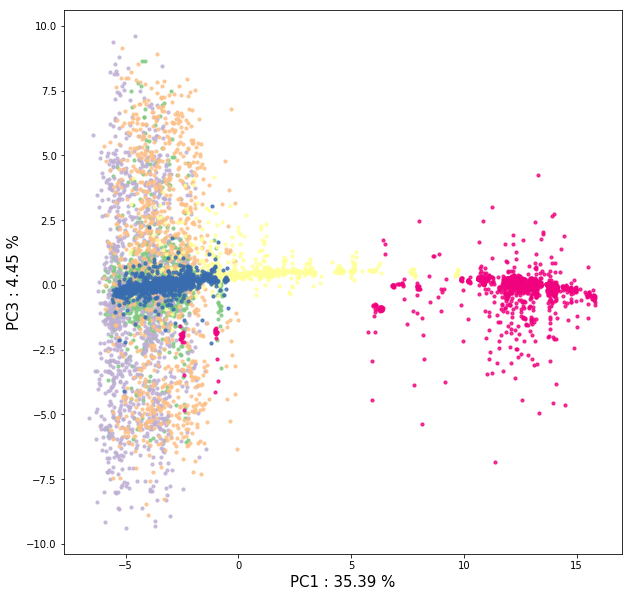

In [15]:
fig = plt.figure(figsize=(10,10), )
ax = fig.add_subplot(1,1,1)
plot_pca(X_r, Y_train_label,fig ,ax ,1 ,3)

**Q** Quelle est l'activité qui semble plus facile à identifier?